In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import tqdm
tqdm.tqdm.pandas()

In [3]:
import pandas as pd
import geopandas as gpd
import utm
from haversine import haversine

In [4]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [5]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [6]:
locations.head()

,0,1
0,42.63914,141.62366
1,36.42835,140.61340
2,42.63864,141.62542
3,36.42911,140.61360
4,36.42957,140.61429


In [7]:
locations.columns = ["lat", "lon"]

In [8]:
locations.max()

lat     78.93490
lon    179.82728
dtype: float64

In [9]:
locations.min()

lat    -54.81624
lon   -179.11254
dtype: float64

(just a check that columns are in the correct order)

In [10]:
def get_utm(lat, lon):
    """Calculate UTM coordinates latitude and longitude."""

    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return pd.Series([easting, northing, zone_number, zone_letter],
                     index=["easting", "northing", "zone_number", "zone_letter"])

if not DATA_DIR.joinpath("locations_utm.csv").exists():
    locations_utm = locations.progress_apply(lambda row: get_utm(row.lat, row.lon), axis=1)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm.csv"))

In [11]:
locations_utm.head()

,easting,northing,zone_number,zone_letter
0,551130.048588,4.720932e+06,54,T
1,465345.985460,4.031530e+06,54,S
2,551274.751185,4.720877e+06,54,T
3,465364.250731,4.031614e+06,54,S
4,465426.304542,4.031665e+06,54,S


# Notation

Given the distance threshold `thr` for connected components calculation, we need the following notation.

## Neighboring zones

Each zone has 8 neighors, we'll mark them as `N, S, E, W, NW, NE, SW, SE` (`Z` is zone of interest, i. e. the one, to which location of interest is located). When dealing with borderline locations, we need to check corresponding neighboring zones.

![Neighboring zones](zones.png)


## Border regions

If a location is near the zone border, we need to consider cross-zone components. All border regions have width of `thr`. If an activity `A` is located border region `N`, we need to check neighboring zone `N` when calculating neighbors of `A`. The full list is the following:

- border region `N` $\rightarrow$ zone `N` (border region `S`)
- border region `S` $\rightarrow$ zone `S` (border region `N`)
- border region `E` $\rightarrow$ zone `E` (border region `W`)
- border region `W` $\rightarrow$ zone `W` (border region `E`)
- border region `N,W` $\rightarrow$ zones `N`, `NW`, `W` (only corresponding border regions)
- border region `S,W` $\rightarrow$ zones `S`, `SW`, `W` (only corresponding border regions)
- border region `N,E` $\rightarrow$ zones `N`, `NE`, `E` (only corresponding border regions)
- border region `S,E` $\rightarrow$ zones `S`, `SE`, `E` (only corresponding border regions)


![Border regions](borders.png)

## Cells

To eliminate unneeded distance checks, we further split each zone into equal cells of size `thr x thr`. Then, at most 9 cells must be checked when seaarching for activity neighbors (some of them may be in a border region of neighboring zone).

![Cells](cells.png)

# Connected components algorithm

## Pre-calculated/pre-filled values

Given a dataframe of `(lat, lon)` locations, we need the following for each location:

- **UTM coordinates** (Pandas dataframe, columns are `["easting", "northing", "zone_number", "zone_letter"]`),
- **borderline status** (`["north", "south", "east", "west"]`, only two can be `True` at max),
- **grid cell tuple** (based on chosen threshold, `["cell_easting", "cell_northing"]`).
- **connected component index column** (filled with `-1`), locations marked as `-1` are considered 

## Algorithm

`S` - all locations, `idx` - current component index.

```
procedure mark(location, component_idx)
    calculate candidate cells [C]
    calculate unmarked neighboring locations [NL] given [C]

    foreach l in [NL]:
        mark l with component_idx
        mark(l, component_idx)

idx = -1

while (have unmarked locations in S)
    idx += 1
    select random unmarked location L
    mark(L, idx)
```

# Small area test without cross-zone components

In [12]:
from shapely.geometry import box

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [14]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
zone_36S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==36)
zone_35S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==35)
locations_israel = locations_utm[zone_36S]
locations_aegean = locations_utm[zone_35S]

locations_israel = gpd.GeoDataFrame(locations_israel,
                                    geometry=gpd.points_from_xy(locations_israel["easting"],
                                                                locations_israel["northing"]),
                                    crs="EPSG:32636")

locations_aegean = gpd.GeoDataFrame(locations_aegean,
                                    geometry=gpd.points_from_xy(locations_aegean["easting"],
                                                                locations_aegean["northing"]),
                                    crs="EPSG:32635")

In [20]:
locations_israel.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 30°E to 36°E - by country
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
locations_aegean.crs

<Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 24°E to 30°E - by country
- bounds: (24.0, 0.0, 30.0, 84.0)
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Don't be confused: 36N is `zone 36 North`, not quadrant `36N`!**

In [27]:
Xc, Yc = 33, 36
DX, DY = 3, 4

minx, miny, maxx, maxy = 24, 32, 36, 40
aoi = box(minx, miny, maxx, maxy)

aoi = world[world.intersects(aoi)]

(3400000.0, 4200000.0)

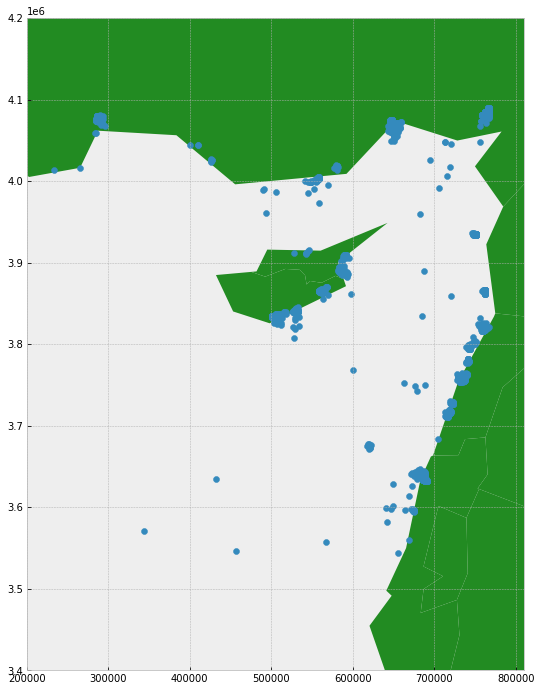

In [28]:
minx, maxx = 200000, 810000
miny, maxy = 3400000, 4200000

plt.figure(figsize=(12,12))
aoi.to_crs("EPSG:32636").plot(color="forestgreen", ax=plt.gca())
locations_israel.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

(3400000.0, 4200000.0)

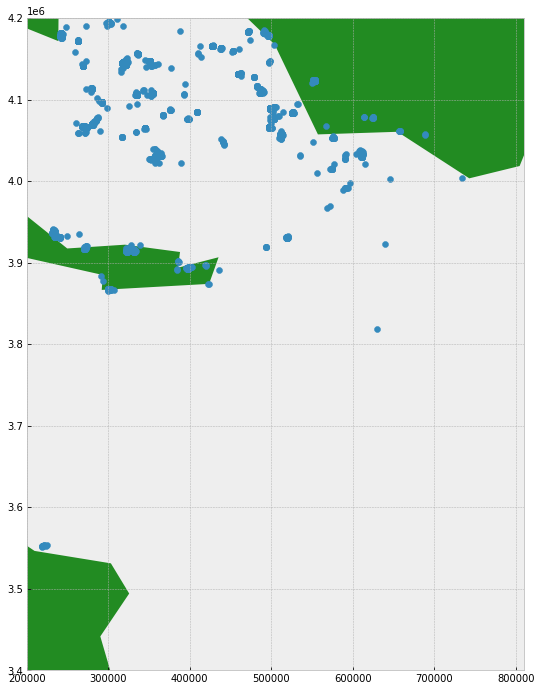

In [33]:
minx, maxx = 200000, 810000
miny, maxy = 3400000, 4200000

plt.figure(figsize=(12,12))
aoi.to_crs("EPSG:32635").plot(color="forestgreen", ax=plt.gca())
locations_aegean.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [35]:
THR = 10000

In [107]:
locs = pd.concat([locations_israel, locations_aegean]).copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [108]:
locs.head()

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y
725,687374.333748,3.638761e+06,36,S,POINT (687374.334 3638760.629),-1,68,363
730,690302.316735,3.632251e+06,36,S,POINT (690302.317 3632250.844),-1,69,363
1024,646438.453401,4.073240e+06,36,S,POINT (646438.453 4073240.365),-1,64,407
1026,688454.788028,3.633349e+06,36,S,POINT (688454.788 3633349.143),-1,68,363
1027,501817.238852,3.833990e+06,36,S,POINT (501817.239 3833990.063),-1,50,383


In [109]:
locs.tail()

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y
1491498,493447.877728,4.291969e+06,35,S,POINT (493447.878 4291968.848),-1,49,429
1492895,495208.391389,4.303113e+06,35,S,POINT (495208.391 4303113.199),-1,49,430
1492896,494411.845760,4.303978e+06,35,S,POINT (494411.846 4303978.169),-1,49,430
1493426,494345.284347,4.298211e+06,35,S,POINT (494345.284 4298211.186),-1,49,429
1493706,492254.835523,4.292446e+06,35,S,POINT (492254.836 4292445.970),-1,49,429


## Convenience routines

In [110]:
def get_in_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""
    return np.sqrt(np.square(locs[["easting", "northing"]] - loc[["easting", "northing"]]).sum(axis=1))


def get_in_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    zone_mask = (locs.zone_number==loc.zone_number) & (locs.zone_letter==loc.zone_letter)
    cand_mask_x = (locs.cell_x==loc.cell_x) | (locs.cell_x==(loc.cell_x-1)) | (locs.cell_x==(loc.cell_x+1))
    cand_mask_y = (locs.cell_y==loc.cell_y) | (locs.cell_y==(loc.cell_y-1)) | (locs.cell_y==(loc.cell_y+1))
    cand_mask = cand_mask_x & cand_mask_y & (locs.component==-1) & zone_mask
    candidates = locs[cand_mask]

    dist = get_in_zone_distances(loc, candidates)
    return candidates[dist<=thr]


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""
    return locs.iloc[:0]


class ConnectedComponent(object):
    """Connected component entity. New elements can be added, and component can check if it's finished."""
    def __init__(self, cid, all_locations, thr):
        self.members = set()
        self.visited = set()
        self.cid = cid
        self.all_locations = all_locations
        self.thr = thr

    def add(self, element):
        self.members.add(element)

    def visit(self, element):
        if element not in self.members:
            raise ValueError(f"element {element} is not in this component")
        self.visited.add(element)

    def is_full(self):
        return self.members==self.visited

    def grow(self, locs=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations

        for element in subset:
            neighbors = get_in_zone_neighbors(self.all_locations.loc[element], locs, self.thr)

            if self.all_locations.loc[element, "border"]:
                cross_zone_neighbors = get_cross_zone_neighbors(self.all_locations.loc[element], locs, self.thr)
                neighbors = pd.concat([neighbors, cross_zone_neighbors])

            self.members.update(neighbors.index)
            self.visited.add(element)

    @property
    def elements(self):
        return list(self.members)

    @property
    def size(self):
        return len(self.members)

In [111]:
get_in_zone_distances(locs.iloc[0], locs.iloc[:100])

725          0.000000
730       7137.953964
1024    436403.927248
1026      5518.293329
1027    269343.585913
            ...      
9215      5692.293896
9216      5725.467472
9217      5650.180756
9218      5813.979991
9219      5295.042348
Length: 100, dtype: float64

In [112]:
locs.iloc[0]

easting                                      687374.333748
northing                                     3638760.62875
zone_number                                             36
zone_letter                                              S
geometry       POINT (687374.3337478098 3638760.628750423)
component                                               -1
cell_x                                                  68
cell_y                                                 363
Name: 725, dtype: object

In [113]:
get_in_zone_neighbors(locs.iloc[0], locs.iloc[:100], THR)

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y
725,687374.333748,3.638761e+06,36,S,POINT (687374.334 3638760.629),-1,68,363
730,690302.316735,3.632251e+06,36,S,POINT (690302.317 3632250.844),-1,69,363
1026,688454.788028,3.633349e+06,36,S,POINT (688454.788 3633349.143),-1,68,363
1037,688327.372099,3.632662e+06,36,S,POINT (688327.372 3632662.306),-1,68,363
1049,688307.570843,3.632866e+06,36,S,POINT (688307.571 3632866.032),-1,68,363
1061,688485.325713,3.633369e+06,36,S,POINT (688485.326 3633368.582),-1,68,363
1073,688285.321695,3.633198e+06,36,S,POINT (688285.322 3633198.385),-1,68,363
1074,685847.004516,3.636702e+06,36,S,POINT (685847.005 3636701.841),-1,68,363
1090,688498.721303,3.632666e+06,36,S,POINT (688498.721 3632665.569),-1,68,363
6948,686130.489929,3.638551e+06,36,S,POINT (686130.490 3638550.746),-1,68,363


In [114]:
# Should be no neighbors, since locs.iloc[0] are locs.iloc[-100:] in different zones 
get_in_zone_neighbors(locs.iloc[0], locs.iloc[-100:], THR)

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y


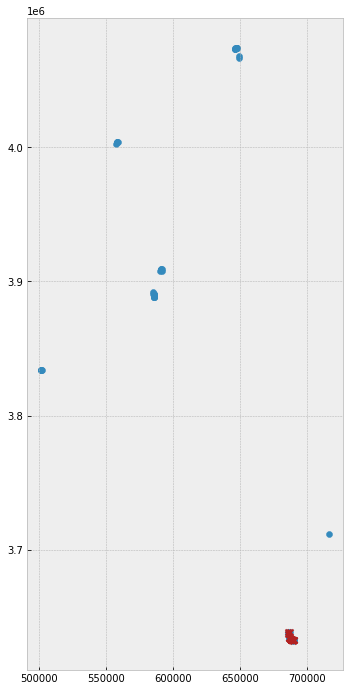

In [115]:
plt.figure(figsize=(12,12))
locs.iloc[:100].plot(ax=plt.gca())
get_in_zone_neighbors(locs.iloc[0], locs.iloc[:100], THR).plot(c="firebrick", ax=plt.gca(), marker="x");

In [116]:
ConnectedComponent?

Init signature: ConnectedComponent(cid, all_locations, thr)
Docstring:      Connected component entity. New elements can be added, and component can check if it's finished.
Type:           type
Subclasses:     


In [117]:
locs["border"] = False

In [118]:
locs.iloc[0]

easting                                      687374.333748
northing                                     3638760.62875
zone_number                                             36
zone_letter                                              S
geometry       POINT (687374.3337478098 3638760.628750423)
component                                               -1
cell_x                                                  68
cell_y                                                 363
border                                               False
Name: 725, dtype: object

In [119]:
c = ConnectedComponent(0, locs, THR)
c.add(725)
c.elements, c.is_full(), c.size

([725], False, 1)

In [120]:
c.visit(725)
c.is_full()

True

In [121]:
c.visit(4)

ValueError: element 4 is not in this component

In [122]:
c.elements, c.is_full(), c.size

([725], True, 1)

In [123]:
c = ConnectedComponent(0, locs, THR)
c.add(725)

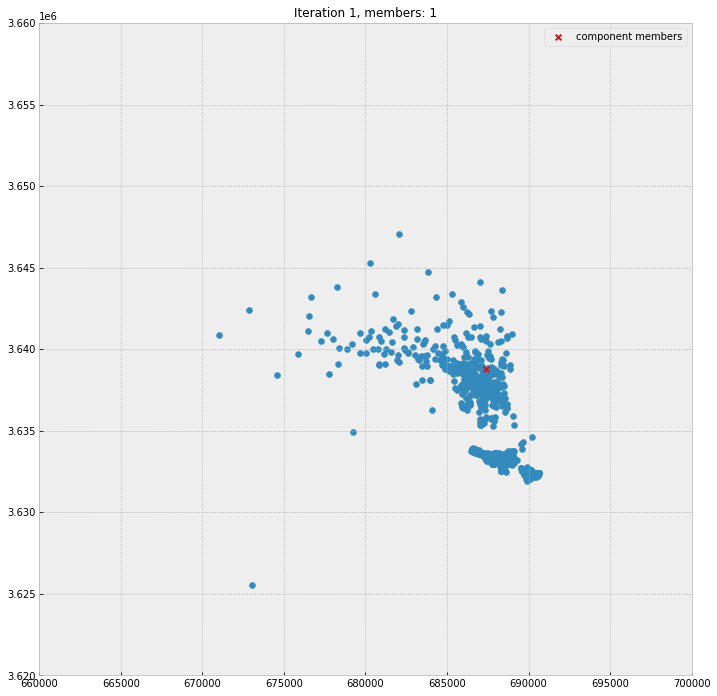

In [124]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=32, label="component members")

plt.legend(loc=0)

plt.xlim(660000, 700000)
plt.ylim(3620000, 3660000)

plt.title(f"Iteration 1, members: {c.size}", fontsize=12);

In [125]:
c.grow(locs)
c.size, c.is_full(), len(c.members.difference(c.visited))

(2125, False, 2124)

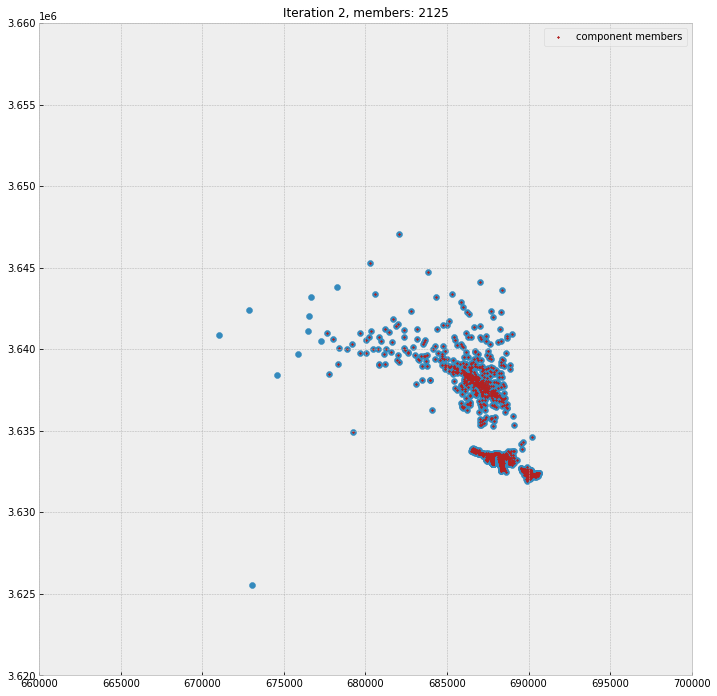

In [126]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.xlim(660000, 700000)
plt.ylim(3620000, 3660000)

plt.title(f"Iteration 2, members: {c.size}", fontsize=12);

In [127]:
c.grow(locs)
c.size, c.is_full(), len(c.members.difference(c.visited))

(2134, False, 9)

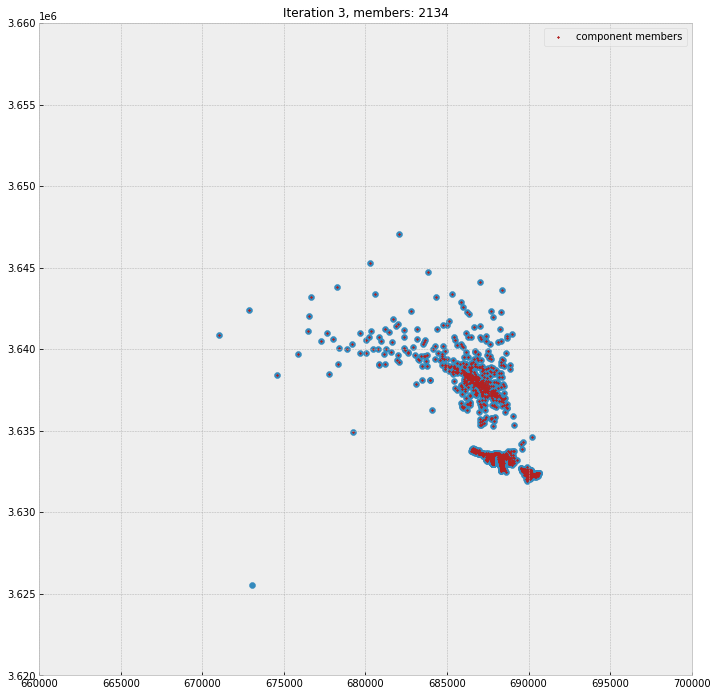

In [128]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.xlim(660000, 700000)
plt.ylim(3620000, 3660000)

plt.title(f"Iteration 3, members: {c.size}", fontsize=12);

In [129]:
c.grow(locs)
c.size, c.is_full(), c.members.difference(c.visited)

(2134, True, set())

In [130]:
locs["component"] = -1
current_cid = -1
components = {}

while (locs.component==-1).sum()!=0:
    current_cid += 1
    seed = locs[locs.component==-1].sample(1).index[0]

    component = ConnectedComponent(current_cid, locs, THR)
    component.add(seed)

    print(f"Starting new component {component.cid}")

    while not component.is_full():
        component.grow(locs)
        print(f"\tGrowing {component.cid}: {component.size}")

    locs.loc[component.elements, "component"] = current_cid
    components[component.cid] = component.elements

Starting new component 0
	Growing 0: 2156
	Growing 0: 2293
	Growing 0: 2297
	Growing 0: 2297
Starting new component 1
	Growing 1: 235
	Growing 1: 244
	Growing 1: 244
Starting new component 2
	Growing 2: 77
	Growing 2: 77
Starting new component 3
	Growing 3: 2094
	Growing 3: 2134
	Growing 3: 2134
Starting new component 4
	Growing 4: 121
	Growing 4: 123
	Growing 4: 214
	Growing 4: 214
Starting new component 5
	Growing 5: 89
	Growing 5: 100
	Growing 5: 102
	Growing 5: 102
Starting new component 6
	Growing 6: 3122
	Growing 6: 3250
	Growing 6: 3255
	Growing 6: 3255
Starting new component 7
	Growing 7: 45
	Growing 7: 45
Starting new component 8
	Growing 8: 365
	Growing 8: 368
	Growing 8: 368
Starting new component 9
	Growing 9: 59
	Growing 9: 59
Starting new component 10
	Growing 10: 448
	Growing 10: 451
	Growing 10: 451
Starting new component 11
	Growing 11: 67
	Growing 11: 67
Starting new component 12
	Growing 12: 219
	Growing 12: 220
	Growing 12: 220
Starting new component 13
	Growing 13:

In [131]:
locs.component.value_counts()

6      3255
0      2297
3      2134
23     1002
18      923
       ... 
55        1
166       1
150       1
134       1
159       1
Name: component, Length: 168, dtype: int64

(3400000.0, 4200000.0)

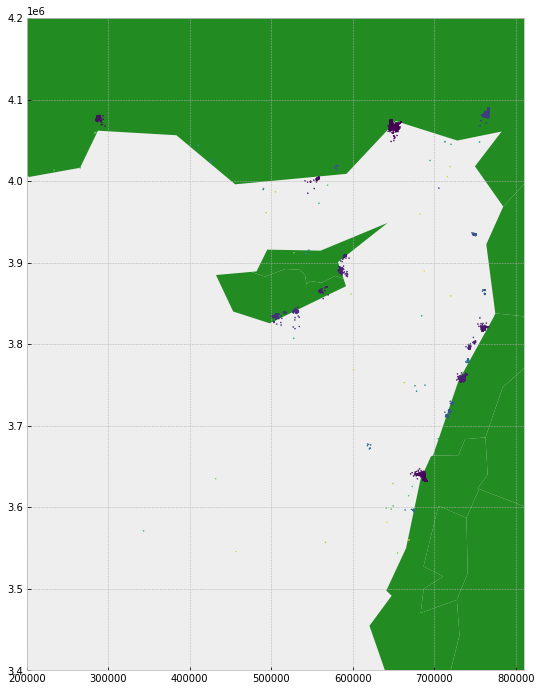

In [132]:
minx, maxx = 200000, 810000
miny, maxy = 3400000, 4200000

plt.figure(figsize=(12,12))
aoi.to_crs("EPSG:32636").plot(color="forestgreen", ax=plt.gca())
locs[locs.zone_number==36].plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

(3400000.0, 4200000.0)

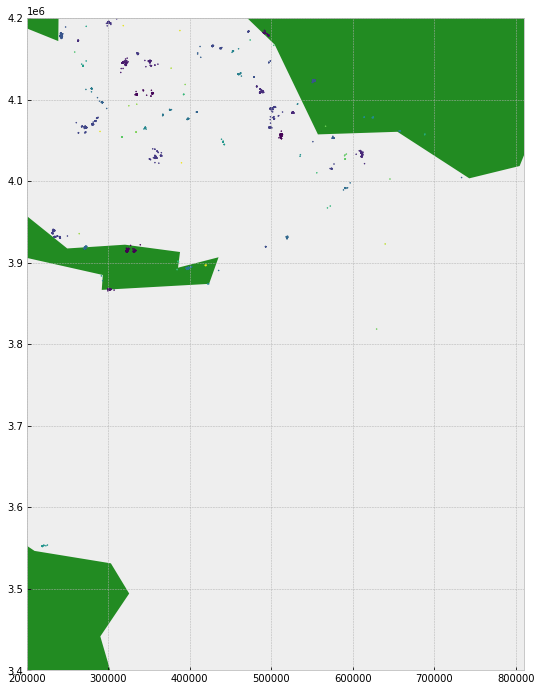

In [133]:
minx, maxx = 200000, 810000
miny, maxy = 3400000, 4200000

plt.figure(figsize=(12,12))
aoi.to_crs("EPSG:32635").plot(color="forestgreen", ax=plt.gca())
locs[locs.zone_number==35].plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [147]:
locs.component.value_counts().head()

6     3255
0     2297
3     2134
23    1002
18     923
Name: component, dtype: int64

In [151]:
locs[locs.component==6]

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y,border
719,490338.345881,4.292125e+06,35,S,POINT (490338.346 4292125.155),6,49,429,False
1087,489563.043341,4.293073e+06,35,S,POINT (489563.043 4293072.685),6,48,429,False
9450,493607.761243,4.292036e+06,35,S,POINT (493607.761 4292036.408),6,49,429,False
18327,493752.347860,4.290327e+06,35,S,POINT (493752.348 4290327.404),6,49,429,False
18334,493777.533091,4.290314e+06,35,S,POINT (493777.533 4290314.069),6,49,429,False
...,...,...,...,...,...,...,...,...,...
1491498,493447.877728,4.291969e+06,35,S,POINT (493447.878 4291968.848),6,49,429,False
1492895,495208.391389,4.303113e+06,35,S,POINT (495208.391 4303113.199),6,49,430,False
1492896,494411.845760,4.303978e+06,35,S,POINT (494411.846 4303978.169),6,49,430,False
1493426,494345.284347,4.298211e+06,35,S,POINT (494345.284 4298211.186),6,49,429,False


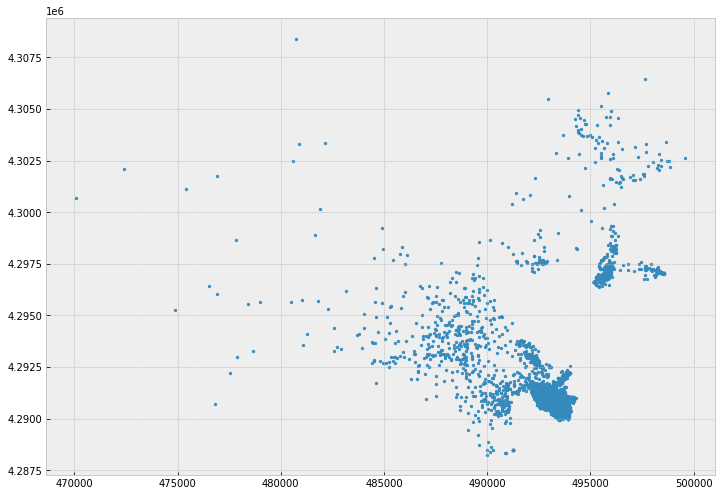

In [152]:
plt.figure(figsize=(12,12))
locs[locs.component==6].plot(ax=plt.gca(), markersize=8)

In [153]:
locs[locs.component==0]

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y,border
1024,646438.453401,4.073240e+06,36,S,POINT (646438.453 4073240.365),0,64,407,False
1036,646332.096798,4.073405e+06,36,S,POINT (646332.097 4073405.003),0,64,407,False
1047,646588.027466,4.074093e+06,36,S,POINT (646588.027 4074093.004),0,64,407,False
1059,646444.100260,4.073795e+06,36,S,POINT (646444.100 4073795.338),0,64,407,False
1071,646289.386638,4.073293e+06,36,S,POINT (646289.387 4073293.296),0,64,407,False
...,...,...,...,...,...,...,...,...,...
1487315,647111.284116,4.073921e+06,36,S,POINT (647111.284 4073921.121),0,64,407,False
1487316,646987.975881,4.073723e+06,36,S,POINT (646987.976 4073722.569),0,64,407,False
1487317,647032.925231,4.069920e+06,36,S,POINT (647032.925 4069920.225),0,64,406,False
1493623,647802.767794,4.074395e+06,36,S,POINT (647802.768 4074394.734),0,64,407,False


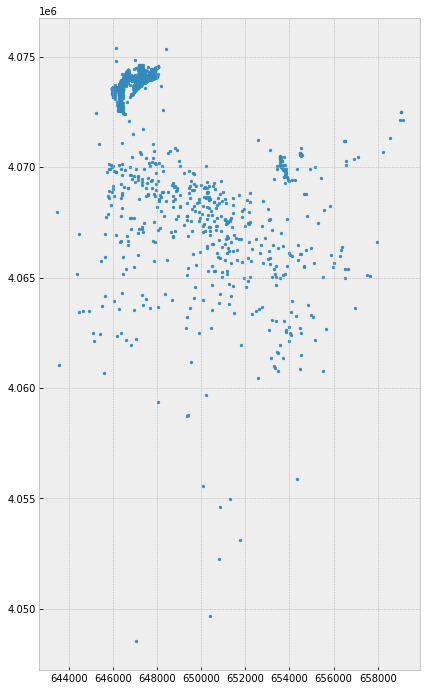

In [154]:
plt.figure(figsize=(12,12))
locs[locs.component==0].plot(ax=plt.gca(), markersize=8)

In [155]:
locs[locs.component==3]

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y,border
725,687374.333748,3.638761e+06,36,S,POINT (687374.334 3638760.629),3,68,363,False
730,690302.316735,3.632251e+06,36,S,POINT (690302.317 3632250.844),3,69,363,False
1026,688454.788028,3.633349e+06,36,S,POINT (688454.788 3633349.143),3,68,363,False
1037,688327.372099,3.632662e+06,36,S,POINT (688327.372 3632662.306),3,68,363,False
1049,688307.570843,3.632866e+06,36,S,POINT (688307.571 3632866.032),3,68,363,False
...,...,...,...,...,...,...,...,...,...
1465208,689778.712894,3.632543e+06,36,S,POINT (689778.713 3632542.507),3,68,363,False
1475827,686659.118689,3.633806e+06,36,S,POINT (686659.119 3633806.488),3,68,363,False
1477095,687249.189406,3.633557e+06,36,S,POINT (687249.189 3633556.970),3,68,363,False
1481449,684557.245577,3.639334e+06,36,S,POINT (684557.246 3639334.284),3,68,363,False


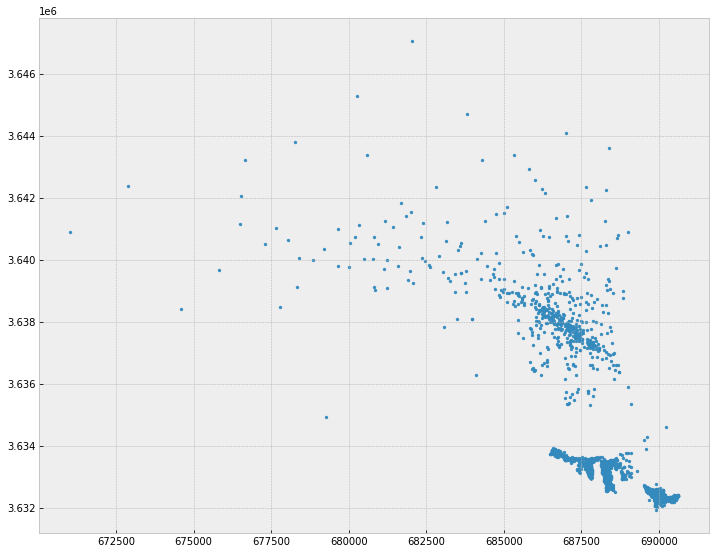

In [156]:
plt.figure(figsize=(12,12))
locs[locs.component==3].plot(ax=plt.gca(), markersize=8)

In [157]:
locs[locs.component==23]

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y,border
1027,501817.238852,3.833990e+06,36,S,POINT (501817.239 3833990.063),23,50,383,False
1038,502061.895275,3.834101e+06,36,S,POINT (502061.895 3834101.004),23,50,383,False
1050,501573.492973,3.833879e+06,36,S,POINT (501573.493 3833879.128),23,50,383,False
1062,501848.389209,3.834028e+06,36,S,POINT (501848.389 3834027.771),23,50,383,False
1075,501542.322289,3.833953e+06,36,S,POINT (501542.322 3833953.419),23,50,383,False
...,...,...,...,...,...,...,...,...,...
1489513,505859.027637,3.836210e+06,36,S,POINT (505859.028 3836209.543),23,50,383,False
1489514,500676.329497,3.833720e+06,36,S,POINT (500676.329 3833720.446),23,50,383,False
1489515,500672.658828,3.833788e+06,36,S,POINT (500672.659 3833788.089),23,50,383,False
1489516,500690.070646,3.833793e+06,36,S,POINT (500690.071 3833792.526),23,50,383,False


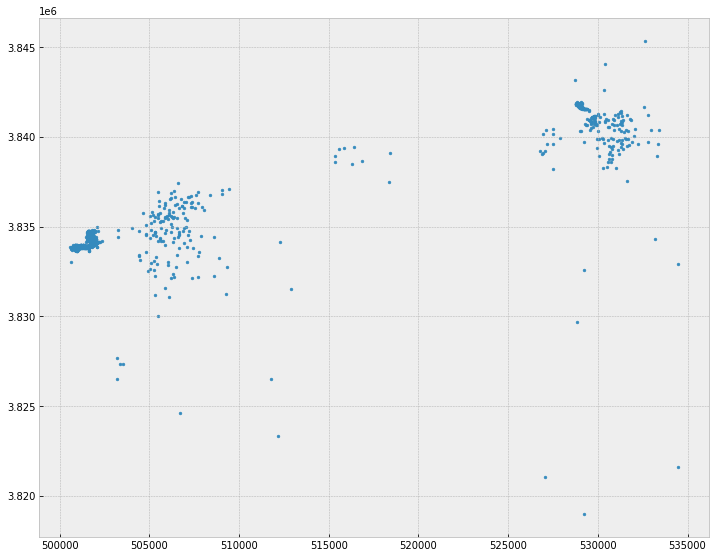

In [158]:
plt.figure(figsize=(12,12))
locs[locs.component==23].plot(ax=plt.gca(), markersize=8)

In [159]:
# Reality check: with the current (only in-the-zone) implementation, all components must be "clean", i.e. contain only one zone
component_zone_counts = (locs.groupby("component")
                         .apply(lambda group: group.zone_number.value_counts())
                         .unstack())

In [160]:
component_zone_counts

,35,36
component,,
0,NaN,2297.0
1,244.0,NaN
2,77.0,NaN
3,NaN,2134.0
4,214.0,NaN
...,...,...
163,NaN,1.0
164,NaN,1.0
165,1.0,NaN


In [161]:
component_zone_counts[component_zone_counts.notnull().sum(axis=1)!=1]

,35,36
component,,


Ok, we do not have any cross-zone components.